# Identifying white water on the coast <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Description
This notebook demonstrates how to identify white water on the coast by computing an index based on reflectance in near-infrared and short wave infrared bands.

***

## Getting started

### Load packages

In [3]:
# Import modules
import os
import sys
import datacube 

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import dea_plotting, dea_datahandling

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [17]:
dc = datacube.Datacube(app='Identifying_white_water')

## Load in Landsat data
Here we use `dea_datahandling.load_ard` to import cloud-free Landsat data from the datacube

In [7]:
# Set up the spatial and temporal bounds of the query
query = {
    'lat': (-28.62, -28.67),
    'lon': (153.60, 153.64),
    'time': ('2017-01-01', '2018-01-10'),
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30)
}

# Only load images with more than 90% cloud free pixels
minimum_cloudfree_perc = 0.9

# Load the data
landsat_ds = dea_datahandling.load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
    group_by='solar_day',
    min_gooddata=minimum_cloudfree_perc,
    **query)

# Keep a record of what pixels are good vs bad (e.g. cloudy or invalid).
# This will be used in the final step to calculate proportions of white
# water observations that account for missing data
good_pixels = ~landsat_ds.nbart_red.isnull()


Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Filtering to 0 out of 22 observations
Loading ga_ls8c_ard_3 data
    Filtering to 12 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 12 observations 


### Plot time series of imagery

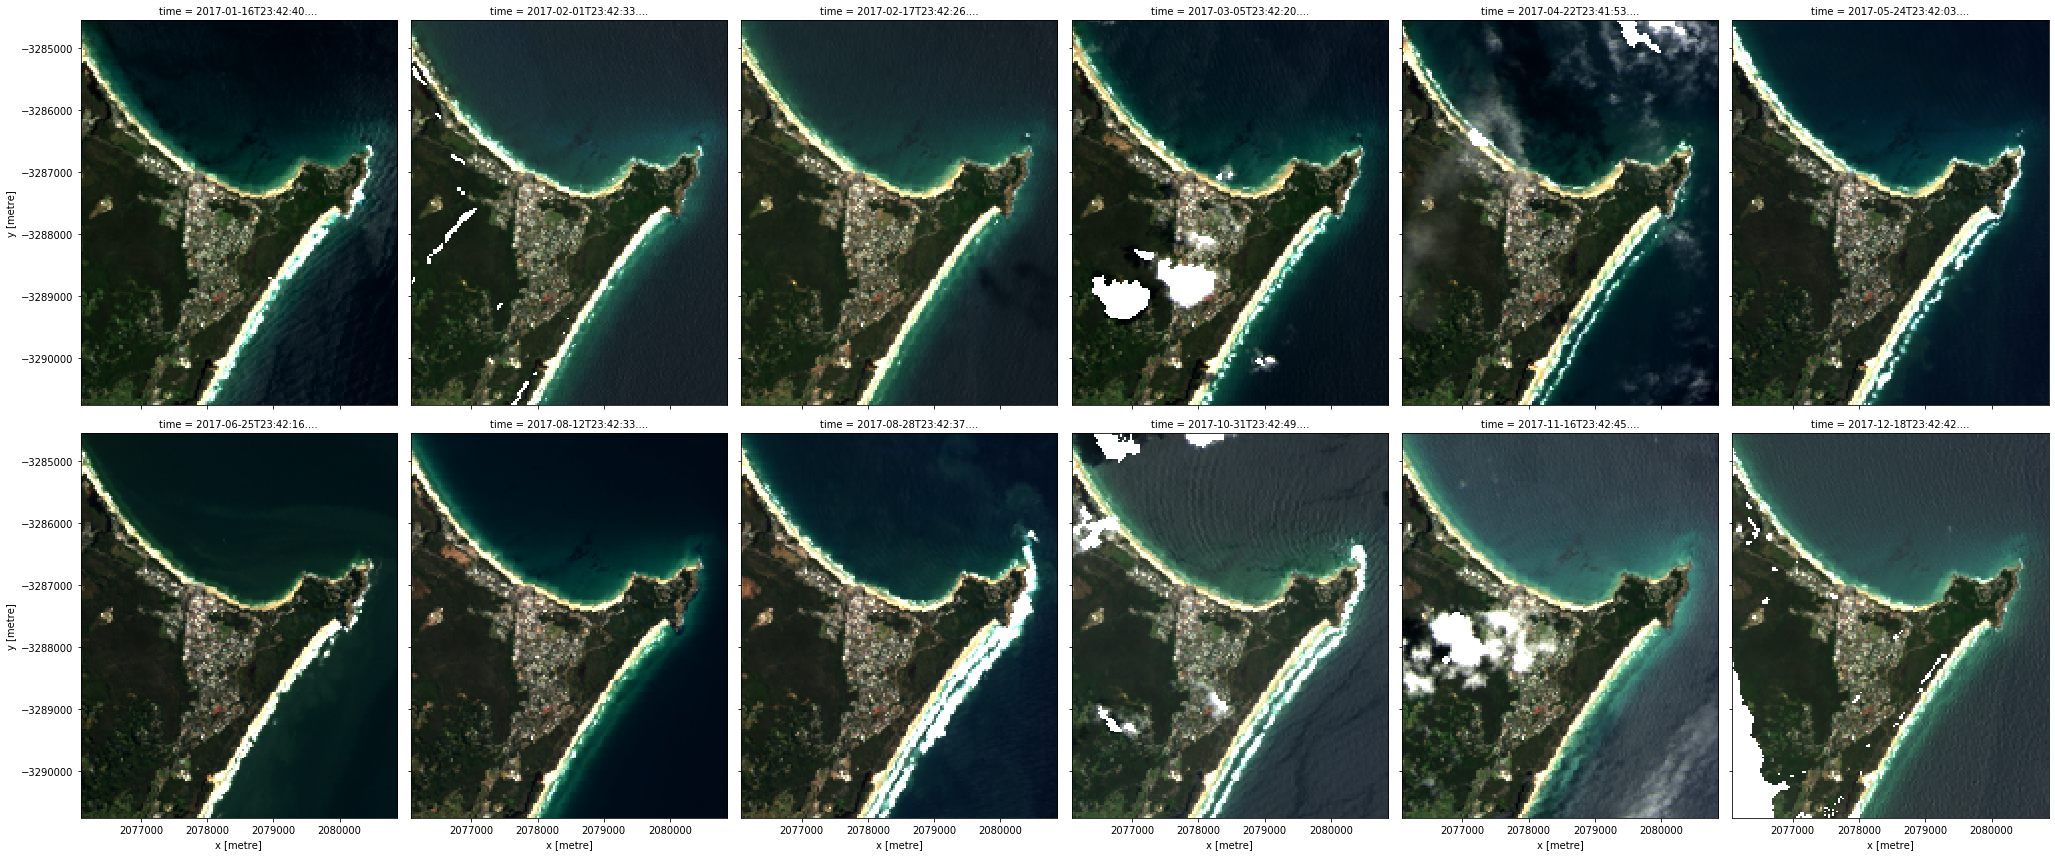

In [8]:
dea_plotting.rgb(landsat_ds, col='time', col_wrap=6)

## Compute index to identify white water 
This uses the ratio of near infrared to shortwave radiation (white water reflects more near infrared than shortwave radiation)

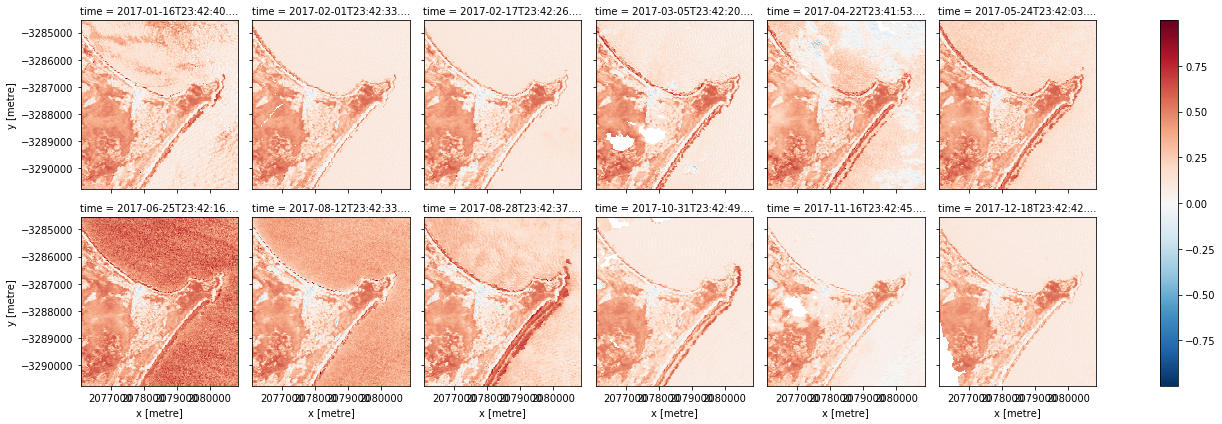

In [11]:
ndwwi = ((landsat_ds.nbart_nir - landsat_ds.nbart_swir_1) / 
         (landsat_ds.nbart_nir + landsat_ds.nbart_swir_1))
ndwwi.plot(col='time', col_wrap=6)

## Mask out land
As this index is intended for use over water, we can use the Modified Normalised Difference Water Index to mask out land pixels

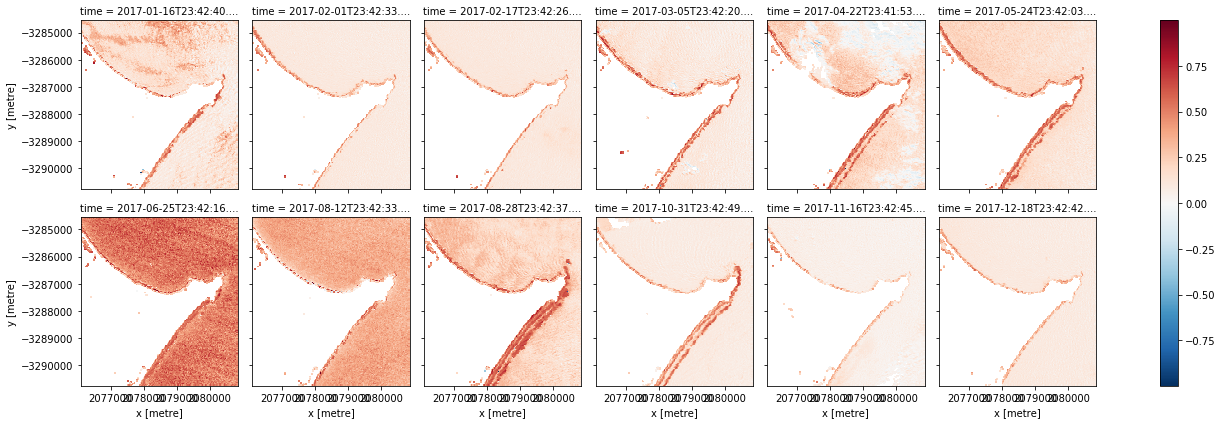

In [12]:
# First, calculate the MNDWI index, then test whether MNDWI value are 
# greater than 0 to create a mask with True = water, False = land
mndwi = ((landsat_ds.nbart_green - landsat_ds.nbart_swir_1) / 
         (landsat_ds.nbart_green + landsat_ds.nbart_swir_1))
land_pixels = mndwi > 0

# Apply this mask to our white water index to remove land pixels
ndwwi_masked = ndwwi.where(land_pixels)

# Plot
ndwwi_masked.plot(col='time', col_wrap=6)

## Apply a threshold to extract white water
We can try and extract white water from the images above by creating a mask where NDWWI is higher than a certain threshold.
We've arbitrarily used 0.5 below - this isn't necessarily the best choice!

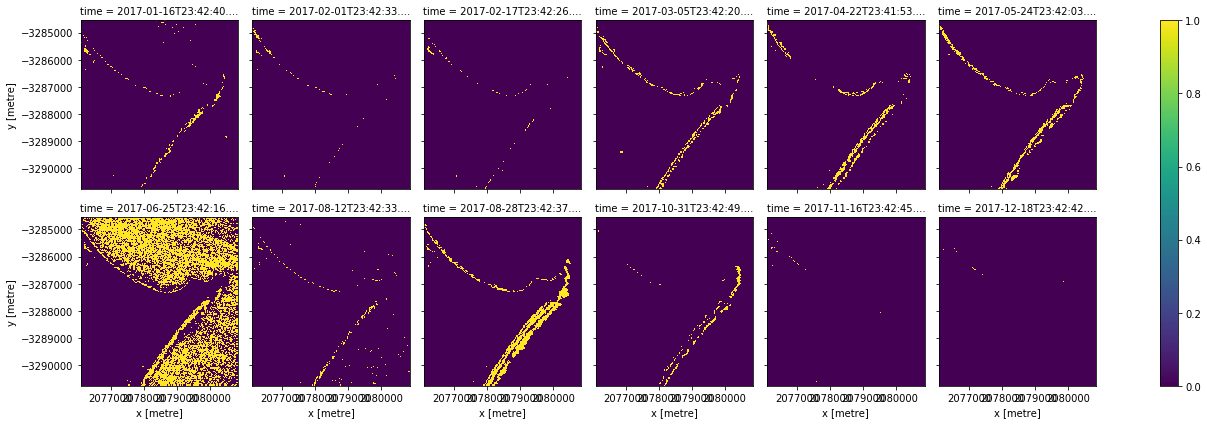

In [13]:
# Choose a threshold value
ndwwi_threshold = 0.5

# Apply the threshold value to the NDWWI data to get back a dataset where True = white water
white_water = ndwwi_masked > ndwwi_threshold

# Plot
white_water.plot(col='time', col_wrap=6)

## Calculate summary/frequency of white water
Now we have a dataset of possible white water, we can summarise it through time. Here we take the mean of all good/non-cloudy pixels through time - this will give us a proportion indicating how often each pixel was observed as white water throughout the time series:

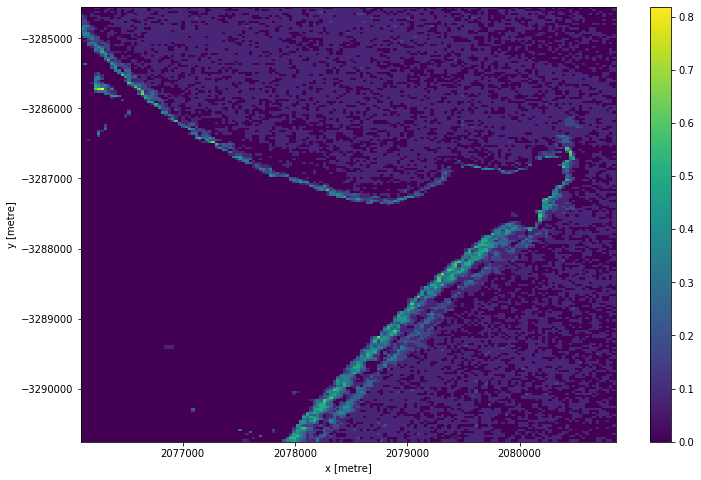

In [14]:
white_water.where(good_pixels).mean(dim='time').plot(size=8)

## Possible extra steps
In the "Apply a threshold" step, several of the images contain false positives in the deeper ocean areas due to certain wind/ocean colour conditions. These issues are in areas of deep blue ocean, so a potential way to fix them could be to filter our data to only keep white water identified in areas with bright white pixels.

Filtering based on the "blue" band could be a way to do this (there's probably many other ways, including developing a more complex index that takes into account water brightness):

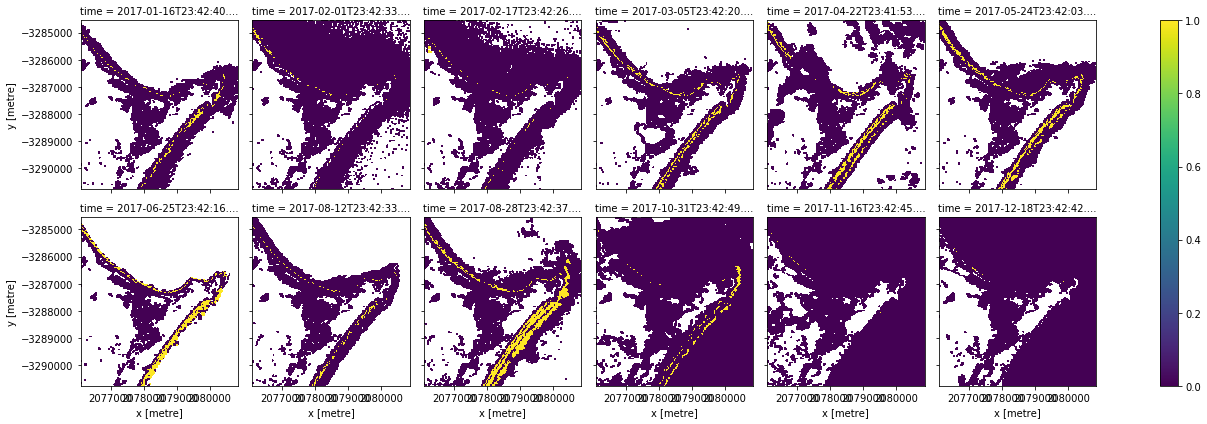

In [16]:
blue_threshold = 500
 
white_water.where(landsat_ds.nbart_blue > blue_threshold).plot(col='time', col_wrap=6)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

<script src="https://embed.github.com/view/geojson/benbalter/dc-wifi-social/master/bars.geojson"></script>
